# Convolutional Neural Networks

While fully connected neural networks are based on the standard multiplication operator (every input feature is multiplied by a weight parameter in the network layer), Convolutional Neural Networks (CNNs) are based on the idea of *convolutional filters* (or kernels) that act as "feature extractors" that pull out certain characteristics in an image (e.g. edge detection).

![](assets/wolf_convolution.png)

There are many convolutional filters that can extract different features in images. Before we discuss how to incorporate convolutions into a deep neural network, let's look at the convolution operation. Given an input image represented as an array of pixel values, the convolution operation is as follows:

![](assets/conv.png)

From this we can see that the number of parameters (i.e. the number of elements in the kernel) does not depend on the input size of the image (whereas the number of parameters in fully connected neural networks depend on the number of input features). The full convolutional step is completed by "sliding" this kernel across the entire image one row and columns at a time. The output of this operation is called a *feature map*.

The overall idea of a convolutional neural network is to apply many of these filters (or kernels) to an image in order to extract different kinds of features; these filters are then stacked sequentially so that many layers act on the output of previous layers. This allows the network to learn more and more complex shapes and features of the input images. After a number of convolutional layers we can then unroll the feature map into a vector. This vector can be thought of as a new set of features for an image. These feature vectors are then fed through a small fully connected neural network to obtain classification probabilities.

![](assets/cnn_arch.png)

While it is not shown in the figure above, many CNNs contain pooling layers between blocks of convolutional layers. Pooling layers reduce the size of the feature maps by different aggregation methods (mean, max, etc.)  applied to blocks of the feature maps. For example, max-pooling is a common option:

![](assets/maxpool.png)

**Note:** Many of the figures above are from [this](https://towardsdatascience.com/demystifying-convolutional-neural-networks-384785791596) very good introductory article.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Download CIFAR10 data

The CIFAR 10 dataset contains low resolution images of 10 different categories.

In [3]:
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
plt.imshow(x_train[3])
plt.title(LABEL_NAMES[y_train[3,0]]);

## Simple(ish) CNN model

Here we will build a small convolutional neural network using a familiar block pattern of CONV -> CONV -> MAXPOOL -> DROPOUT. This network has two such blocks followed by a fully connected layer with RELU activation followed by a softmax output layer. In terms of modern CNNs, this model is quite small but should obtain reasonable results with a fairly short training time (i.e., 10s / epoch on GPU and 4 min / epoch on CPU)

In [6]:
# Define the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
model.summary()

In [8]:
model.fit(x_train / 255, y_train, batch_size=64, shuffle=True, epochs=30, validation_data=(x_test / 255, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.5722 - acc: 0.4232 - val_loss: 1.1894 - val_acc: 0.5726
Epoch 2/30
50000/50000 [==============================] - 9s 175us/step - loss: 1.1218 - acc: 0.6008 - val_loss: 0.9573 - val_acc: 0.6601
Epoch 3/30
50000/50000 [==============================] - 9s 181us/step - loss: 0.9526 - acc: 0.6651 - val_loss: 0.8689 - val_acc: 0.6957
Epoch 4/30
50000/50000 [==============================] - 9s 178us/step - loss: 0.8416 - acc: 0.7037 - val_loss: 0.7610 - val_acc: 0.7324
Epoch 5/30
50000/50000 [==============================] - 9s 179us/step - loss: 0.7660 - acc: 0.7306 - val_loss: 0.7338 - val_acc: 0.7462
Epoch 6/30
50000/50000 [==============================] - 9s 173us/step - loss: 0.7083 - acc: 0.7516 - val_loss: 0.7384 - val_acc: 0.7454
Epoch 7/30
50000/50000 [==============================] - 9s 177us/step - loss: 0.6597 - acc: 0.7683 - val_loss: 0.6730 -

Plotting the training and validation accuracies lets us see that the model is not generalizing very well and is overfitting since the training accuracy is larger than the validation accuracy and the validation accuracy has saturated while the training accuracy is continuing to increase with each epoch.

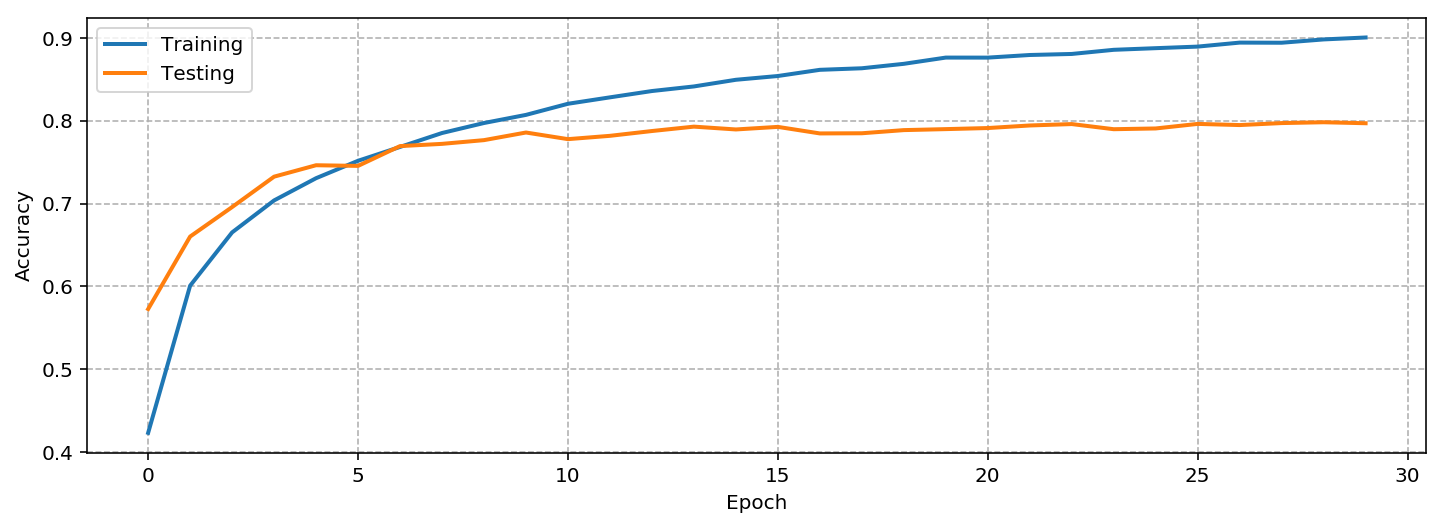

In [12]:
h = model.history.history

plt.figure(figsize=(12,4))
plt.plot(model.history.epoch, h['acc'], lw=2, label='Training')
plt.plot(model.history.epoch, h['val_acc'], lw=2, label='Testing')
plt.grid(ls='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Making predictions

Now we will use our trained model to make predictions. For this classification model the output of the predictions will be a length 10 (number of classes) vector of probabilities corresponding to each class.

In [8]:
# cooking show magic - load trained weights from repo (training done using cells just above)
model.load_weights("cnn-weights.h5")

In [9]:
preds = model.predict(x_test / 255)

## Look at some correct and incorrect predictions

In [10]:
correct_ids = np.argmax(preds, axis=1) == y_test.flatten()
xc, yc, ypc = x_test[correct_ids], y_test[correct_ids,0], np.argmax(preds, axis=1)[correct_ids]
xi, yi, ypi = x_test[~correct_ids], y_test[~correct_ids, 0], np.argmax(preds, axis=1)[~correct_ids]

In [ ]:
# CORRECT RESULTS
plt.figure(figsize=(32,8))
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(xc[ii])
    plt.title(LABEL_NAMES[yc[ii]])
    plt.title(f'Predicted: {LABEL_NAMES[ypc[ii]]}     Correct: {LABEL_NAMES[yc[ii]]}')

In [ ]:
# INCORRECT RESULTS
plt.figure(figsize=(32,8))
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(xi[ii])
    plt.title(f'Predicted: {LABEL_NAMES[ypi[ii]]}     Correct: {LABEL_NAMES[yi[ii]]}')

# Saving model

When saving the model you can either save only the weights or the entire model.

### Just weights

Saving only the weights is more lightweight (in terms of memory) and these weights can usually be transferred between different frameworks (Tensorflow, Pytorch, etc) with minimal effort. One downside of just saving the weights is that you will need to have the model architecture defined prior to loading in the weights.

In [17]:
?model.save_weights

In [ ]:
model.save_weights('cnn-weights.h5')

In [7]:
# load in model weights
model.load_weights('cnn-weights.h5')

### Entire model

Saving the entire model saves the weights, the model architecture, any callbacks and the optimizer. Saving models this way makes it easier to reload your model completely from a file without having to remember the architecture exactly. The downside is that this format cannot be transferred to different frameworks as easily. Furthermore, you may run into problems with code versions and loading in older models. For example, a tensorflow model made with v1.6.0 may not load correctly with 1.11.0.

In [49]:
?tf.keras.models.save_model

Signature: tf.keras.models.save_model(model, filepath, overwrite=True, include_optimizer=True)
Docstring:
Saves a model to a HDF5 file.

The saved model contains:
    - the model's configuration (topology)
    - the model's weights
    - the model's optimizer's state (if any)

Thus the saved model can be reinstantiated in
the exact same state, without any of the code
used for model definition or training.

Arguments:
    model: Keras model instance to be saved.
    filepath: One of the following:
        - String, path where to save the model
        - `h5py.File` object where to save the model
    overwrite: Whether we should overwrite any existing
        model at the target location, or instead
        ask the user with a manual prompt.
    include_optimizer: If True, save optimizer's state together.

Raises:
    ImportError: if h5py is not available.
File:      ~/.conda/envs/eng-ml-bootcamp/lib/python3.6/site-packages/tensorflow/python/keras/engine/saving.py
Type:      function


In [52]:
model.save('cnn-model.h5')

In [53]:
# load in model
new_model = tf.keras.models.load_model('cnn-model.h5')

In [54]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
__________